# Day49-50

## 確認套件版本

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

if(tf.__version__.split(".")[0]!=1):
    exit

try:
    import keras
except:
    !pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本
    
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# # 下載基於 keras 的 yolov3 程式碼
# %cd 'gdrive/My Drive'

Using TensorFlow backend.


## 程式下載

In [2]:
if not os.path.exists("keras-yolo3"):
    !git clone https://github.com/qqwweee/keras-yolo3
os.chdir("keras-yolo3")

if not os.path.exists("model_data/yolo.h5"):
    # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")

Model exist


In [3]:
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

## 資料處理

In [4]:
from glob import glob
from sklearn.model_selection import train_test_split

In [5]:
# 下載資料集
if not os.path.exists("images"):
    from pathlib import Path
    Path("./images").mkdir(parents=True, exist_ok=True)
    os.system("cd images && git clone https://github.com/experiencor/kangaroo.git")
    os.system("cd images && git clone https://github.com/experiencor/raccoon_dataset.git")
    print("data downloaded")
else:
    print("data exists")

data exists


In [6]:
annotation_path = 'exam_train.txt'
log_dir = 'logs/'
classes_path = 'images/classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

In [7]:
kangaroo_img = glob("./images/kangaroo/images/*.jpg")
kangaroo_xml = glob("./images/kangaroo/annots/*.xml")
raccoon_img = glob("./images/raccoon_dataset/images/*.jpg")
raccoon_xml = glob("./images/raccoon_dataset/annotations/*.xml")
img_set = (kangaroo_img + raccoon_img)
xml_set = (kangaroo_xml + raccoon_xml)
train_img, test_img, train_xml, test_xml = train_test_split(
    img_set,
    xml_set,
    test_size=0.23,
    random_state=None,
    shuffle=True)

In [8]:
if not os.path.exists(annotation_path):
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    sets=['train', 'val']

    classes = ["kangaroo", "raccoon"]

    def convert_annotation(image_id, xml_path):
        tree=ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
#             cls = obj.find('name').text
#             if cls not in classes or int(difficult)==1:
#                 continue
#             cls_id = classes.index(cls)
            cls_id = 0 if classes[0] in xml_path else 1
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    wd = "."

    for name, img, xml in [('exam_train', train_img, train_xml), ('exam_test', test_img, test_xml)]:
        image_ids = img
        annotation_path = f'{name}.txt'
        list_file = open(annotation_path, 'w')
        print(f"save annotation at {annotation_path}")
        for num, image_id in enumerate(image_ids):
            list_file.write(image_id)
            convert_annotation(image_id, xml[num])
            list_file.write('\n')
        list_file.close()

In [9]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [10]:
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [11]:
import numpy as np
# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)

num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

In [12]:
if not os.path.exists(log_dir + 'trained_weights_final.h5'):
    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
    else:
        model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [13]:
if not os.path.exists(log_dir + 'trained_weights_final.h5'):
    if not os.path.exists(log_dir + 'trained_weights_stage_1.h5'):
        model.compile(optimizer=Adam(lr=1e-3), loss={
            'yolo_loss': lambda y_true, y_pred: y_pred})
        batch_size = 16
        print(f'Train on {num_train} samples, val on {num_val} samples, with batch size {batch_size}.')
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=150,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')
    else:
        model.load_weights(log_dir + 'trained_weights_stage_1.h5')

In [14]:
if not os.path.exists(log_dir + 'trained_weights_final.h5'):
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')
    batch_size = 1 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=300,
        initial_epoch=150,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')
    os.remove(log_dir + 'trained_weights_stage_1.h5')

In [15]:
from PIL import Image
image = Image.open(lines[-1].split()[0]) 

In [16]:
from yolo import YOLO, detect_video

logs/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (213, 45) (540, 395)
3.3694171


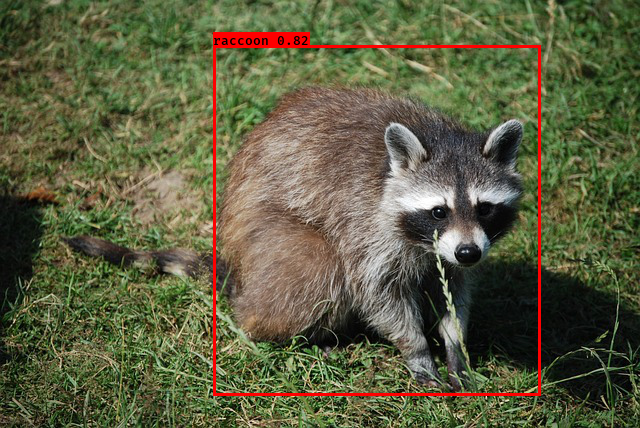

In [17]:
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)
r_image

In [18]:
if not os.path.exists('Raccoon.mp4'):
    os.system("wget https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Kangaroo.mp4")
if not os.path.exists('Kangaroo.mp4'):
    os.system("wget https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Raccoon.mp4")

In [19]:
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
if not os.path.exists('output.mp4'):
    detect_video(yolo_model,'Raccoon.mp4','output.mp4')
if not os.path.exists('output2.mp4'):
    detect_video(yolo_model,'Kangaroo.mp4','output2.mp4')

logs/trained_weights_final.h5 model, anchors, and classes loaded.
